In [14]:
import string
import re
import tensorflow as tf
from pickle import load
from pickle import dump
from numpy import array
from numpy.random import rand
from numpy.random import shuffle
from unicodedata import normalize


# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
 

# split a loaded document into sentences
def to_pairs(doc):
    lines = doc.strip().split('\n')
    pairs = [line.split('\t') for line in  lines]
    return pairs


# clean a list of lines
def clean_pairs(lines):
    cleaned = list()
    # prepare regex for char filtering
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for pair in lines:
        clean_pair = list()
        for line in pair:
            # normalize unicode characters
            line = normalize('NFD', line).encode('ascii', 'ignore')
            line = line.decode('UTF-8')
            # tokenize on white space
            line = line.split()
            # convert to lowercase
            line = [word.lower() for word in line]
            # remove punctuation from each token
            line = [word.translate(table) for word in line]
            # remove non-printable chars form each token
            line = [re_print.sub('', w) for w in line]
            # remove tokens with numbers in them
            line = [word for word in line if word.isalpha()]
            # store as string
            clean_pair.append(' '.join(line))
            cleaned.append(clean_pair)
    return array(cleaned)
 

# save a list of clean sentences to file
def save_clean_data(sentences, filename):
    dump(sentences, open(filename, 'wb'))
    print('Saved: %s' % filename)


# load a clean dataset
def load_clean_sentences(filename):
    return load(open(filename, 'rb'))
 
# save a list of clean sentences to file
def save_clean_data(sentences, filename):
    dump(sentences, open(filename, 'wb'))
    print('Saved: %s' % filename)

# load dataset
filename = '/content/drive/MyDrive/NMT-English-to-German/Dataset/deu.txt'
doc = load_doc(filename)
# split into english-german pairs
pairs = to_pairs(doc)
# clean sentences
clean_pairs = clean_pairs(pairs)
# save clean pairs to file
save_clean_data(clean_pairs, 'english-german.pkl')
# spot check
for i in range(10):
    print('[%s] => [%s]' % (clean_pairs[i,0], clean_pairs[i,1]))

# load dataset
raw_dataset = load_clean_sentences('english-german.pkl')
 
# reduce dataset size
n_sentences = 25000
dataset = raw_dataset[:n_sentences, :]
# random shuffle
shuffle(dataset)
# split into train/test
train, test = dataset[:20000], dataset[20000:]
# save
save_clean_data(dataset, 'english-german-both.pkl')
save_clean_data(train, 'english-german-train.pkl')
save_clean_data(test, 'english-german-test.pkl')

Saved: english-german.pkl
[hi] => [hallo]
[hi] => [hallo]
[hi] => [gru gott]
[hi] => [gru gott]
[run] => [lauf]
[run] => [lauf]
[wow] => [potzdonner]
[wow] => [potzdonner]
[wow] => [donnerwetter]
[wow] => [donnerwetter]
Saved: english-german-both.pkl
Saved: english-german-train.pkl
Saved: english-german-test.pkl


In [15]:
# load a clean dataset
def load_clean_sentences(filename):
    return load(open(filename, 'rb'))
 
# load datasets
dataset = load_clean_sentences('english-german-both.pkl')
train = load_clean_sentences('english-german-train.pkl')
test = load_clean_sentences('english-german-test.pkl')

In [16]:
# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [17]:
def max_length(lines):
    return max(len(line.split()) for line in lines)


# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])

print('The English Vocabulary Size: %d' % eng_vocab_size)
print('The English Max Length: %d' % (eng_length))

# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
print('The German Vocabulary Size: %d' % ger_vocab_size)
print('The German Max Length: %d' % (ger_length))

The English Vocabulary Size: 2814
The English Max Length: 5
The German Vocabulary Size: 4499
The German Max Length: 10


In [18]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    X = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=length, padding='post')
    return X

In [19]:
# one hot encode target sequence
def encode_output(sequences, vocab_size):
    ylist = list()
    for sequence in sequences:
        encoded = tf.keras.utils.to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y

In [20]:
# prepare training data
X_train = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
y_train = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
y_train = encode_output(y_train, eng_vocab_size)

# prepare validation data
X_test = encode_sequences(ger_tokenizer, ger_length, test[:, 1])
y_test = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
y_test = encode_output(y_test, eng_vocab_size)

In [21]:
# define NMT model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
    model.add(tf.keras.layers.LSTM(n_units))
    model.add(tf.keras.layers.RepeatVector(tar_timesteps))
    model.add(tf.keras.layers.LSTM(n_units, return_sequences=True))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(tar_vocab, activation='softmax')))
    return model
 
# Define model
model = define_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 256)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False))

# summarize defined model
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10, 256)           1151744   
                                                                 
 lstm_2 (LSTM)               (None, 256)               525312    
                                                                 
 repeat_vector_1 (RepeatVect  (None, 5, 256)           0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 5, 256)            525312    
                                                                 
 time_distributed_1 (TimeDis  (None, 5, 2814)          723198    
 tributed)                                                       
                                                                 
Total params: 2,925,566
Trainable params: 2,925,566
No

In [22]:
# fit model
filename = 'Model.h5'

checkpoint = tf.keras.callbacks.ModelCheckpoint(filename, monitor='val_loss', 
                                                verbose=1, save_best_only=True, mode='min')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                  patience=10)

history = model.fit(X_train, y_train, 
                    epochs=1024, 
                    batch_size=1024, 
                    validation_split=0.25, 
                    callbacks=[checkpoint, early_stopping],)


Epoch 1/1024
15/15 [==============================] - ETA: 0s - loss: 7.5989
Epoch 1: val_loss improved from inf to 5.65841, saving model to Model.h5
15/15 [==============================] - 10s 312ms/step - loss: 7.5989 - val_loss: 5.6584
Epoch 2/1024
15/15 [==============================] - ETA: 0s - loss: 4.7762
Epoch 2: val_loss improved from 5.65841 to 4.56897, saving model to Model.h5
15/15 [==============================] - 3s 193ms/step - loss: 4.7762 - val_loss: 4.5690
Epoch 3/1024
15/15 [==============================] - ETA: 0s - loss: 4.4116
Epoch 3: val_loss improved from 4.56897 to 4.37043, saving model to Model.h5
15/15 [==============================] - 2s 150ms/step - loss: 4.4116 - val_loss: 4.3704
Epoch 4/1024
15/15 [==============================] - ETA: 0s - loss: 4.2257
Epoch 4: val_loss improved from 4.37043 to 4.20816, saving model to Model.h5
15/15 [==============================] - 2s 124ms/step - loss: 4.2257 - val_loss: 4.2082
Epoch 5/1024
15/15 [===========

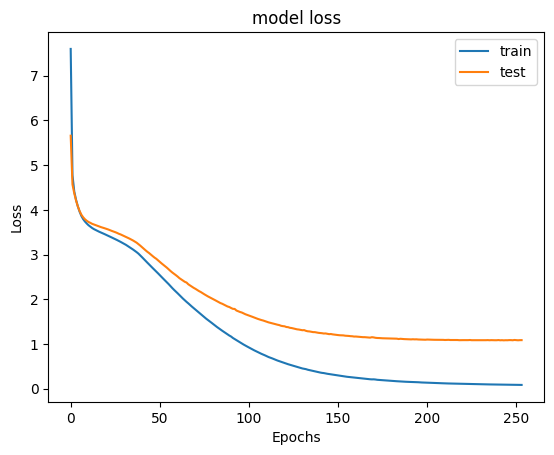

In [25]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Evaluation of the trained LSTM Encoder-Decoder Model

In [27]:
# load datasets
dataset = load_clean_sentences('english-german-both.pkl')
train = load_clean_sentences('english-german-train.pkl')
test = load_clean_sentences('english-german-test.pkl')

# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])

# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])

# prepare data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])

In [29]:
from pickle import load
from numpy import array
from numpy import argmax
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
 

# load a clean dataset
def load_clean_sentences(filename):
    return load(open(filename, 'rb'))
 
# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
 

# max sentence length
def max_length(lines):
    return max(len(line.split()) for line in lines)
 
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    X = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    X = pad_sequences(X, maxlen=length, padding='post')
    return X
 

# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
 

# generate target given source sequence
def predict_sequence(model, tokenizer, source):
    prediction = model.predict(source, verbose=0)[0]
    integers = [argmax(vector) for vector in prediction]
    target = list()
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)
 

# evaluate the skill of the model
def evaluate_model(model, tokenizer, sources, raw_dataset):
    actual, predicted = list(), list()
    for i, source in enumerate(sources):
        # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_sequence(model, eng_tokenizer, source)
        raw_target, raw_src = raw_dataset[i]
        if i < 10:
            print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
        actual.append([raw_target.split()])
        predicted.append(translation.split())

    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
 

# load datasets
dataset = load_clean_sentences('english-german-both.pkl')
train = load_clean_sentences('english-german-train.pkl')
test = load_clean_sentences('english-german-test.pkl')

# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])

# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])

# prepare data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])

# load model
model = load_model('Model.h5')

# test on some training sequences
print('train')
evaluate_model(model, eng_tokenizer, trainX, train)

# test on some test sequences
print('test')
evaluate_model(model, eng_tokenizer, testX, test)

train
src=[er besitzt ubersinnliche krafte], target=[he is a psychic], predicted=[he is a psychic]
src=[versucht es noch mal], target=[try again], predicted=[try it once]
src=[druck mich], target=[give me a hug], predicted=[give me a hug]
src=[tom hat sich verandert], target=[tom changed], predicted=[tom changed]
src=[wie geht es euch heute], target=[how are you today], predicted=[how are you today]
src=[hier hast du deinen salat], target=[heres your salad], predicted=[heres your salad]
src=[darf ich dir helfen], target=[may i help you], predicted=[can i help you]
src=[ich habe eine armbanduhr gekauft], target=[i bought a watch], predicted=[i bought a watch]
src=[tut mir leid deswegen], target=[sorry about that], predicted=[sorry about that]
src=[lassen sie alles zuruck], target=[leave everything], predicted=[leave everything]
BLEU-1: 0.920375
BLEU-2: 0.898648
BLEU-3: 0.854116
BLEU-4: 0.649271
test
src=[er ist ein groer bub], target=[he is a tall boy], predicted=[hes in good]
src=[ich 